# 数据降维

小说《三体》中的终极武器是降维打击，这里的概念是相近的。

常用的算法| 简述
:-|-:
主成分分析PCA|转换后样本方差最大的线性降维方式
线性判别分析LDA|类似PCA，但对带标签数据效果更好
等距映射Isomap|降维后依然保持近邻点间结构不变的流形学习方法
局部线性嵌入LLE|假设样本在局部空间满足线性关系的流形学习方法
谱聚类|先用Laplacian Eigenmaps进行流形学习降维，再聚类的方法
t-SNE|用概率建模的流形学习方法

### 主成分分析

求样本最大方差的方法：

- 特征值
- 奇异值分解

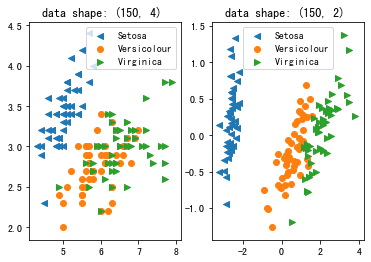

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

plt.subplot(1,2,1)
for name, label, m in [('Setosa', 0, '<'), ('Versicolour', 1, 'o'), ('Virginica', 2, '>')]:
    plt.scatter(X[y==label, 0], X[y==label, 1], label=name, marker=m)

plt.legend()
plt.title("data shape: %s "%(X.shape,))
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

plt.subplot(1,2,2)
for name, label, m in [('Setosa', 0, '<'), ('Versicolour', 1, 'o'), ('Virginica', 2, '>')]:
    plt.scatter(X[y==label, 0], X[y==label, 1], label=name, marker=m)

plt.legend()
plt.title("data shape: %s "%(X.shape,))

plt.show()

### 线性判别分析

相比PCA，多考虑了每种标签样本数据集内的分布情况，即“最大化类间样本的方差，最小化类内样本的方差”。因此它们算法差别在于，PCA计算所有数据协方差矩阵的特征值/特征向量，而LDA计算的是类内协方差矩阵的逆与类间协方差矩阵乘积的特征值/特征向量。

LDA缺点是降维后的最大维数既受特征数量，也受原始数据维度影响，PCA仅受原始数据维度影响。

**在sklearn中LinearDiscriminantAnalysis既是一个监督分类器，也是一个降维器。**

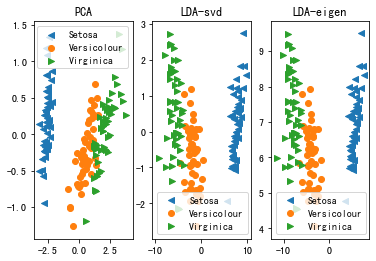

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

iris = datasets.load_iris()
X = iris.data
y = iris.target

plt.subplot(131)
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X)

for name, label, m in [('Setosa', 0, '<'), ('Versicolour', 1, 'o'), ('Virginica', 2, '>')]:
    plt.scatter(X_pca[y==label, 0], X_pca[y==label, 1], label=name, marker=m)

plt.legend()
plt.title("PCA")

plt.subplot(132)
lda_svd = LDA(n_components=2, solver="svd").fit(X,y)
X_lda_svd = lda_svd.transform(X)

for name, label, m in [('Setosa', 0, '<'), ('Versicolour', 1, 'o'), ('Virginica', 2, '>')]:
    plt.scatter(X_lda_svd[y==label, 0], X_lda_svd[y==label, 1], label=name, marker=m)

plt.legend()
plt.title("LDA-svd")

plt.subplot(133)
lda = LDA(n_components=2, solver="eigen").fit(X,y)
X_lda = lda.transform(X)

for name, label, m in [('Setosa', 0, '<'), ('Versicolour', 1, 'o'), ('Virginica', 2, '>')]:
    plt.scatter(X_lda[y==label, 0], X_lda[y==label, 1], label=name, marker=m)

plt.legend()
plt.title("LDA-eigen")

plt.show()

如果将上面的LDA降维策略从svd换成eigen，下图将这些点在折线图中，做对比

很明显，可以发现，数据分布还是比较统一的，差别是延坐标轴做了平移

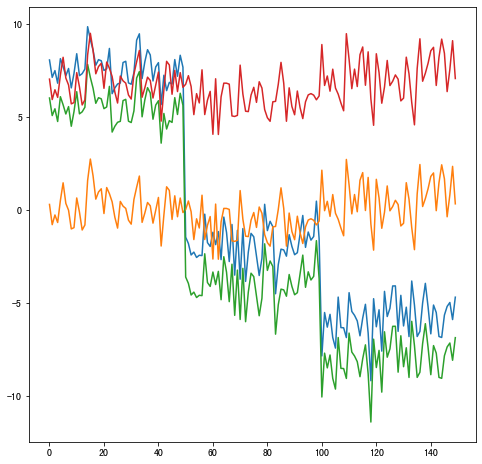

In [3]:
fig=plt.figure(figsize=(8,8))
plt.plot(X_lda_svd)
plt.plot(X_lda)

降维之后，无法从视觉感知降维的效果时，可以计算方差比，若总和小于1，说明丢失了部分信息。一般可以用“降维保留了百分之多少的方差比”形容降维效果。

In [4]:
print(pca.explained_variance_ratio_)
print(lda_svd.explained_variance_ratio_)
print(lda.explained_variance_ratio_)

[0.92461872 0.05306648]
[0.9912126 0.0087874]
[0.9912126 0.0087874]


### 流形学习之Isomap

流形学习是非线性降维的主要方法。流形（manifold）是局部具有欧几里得性质的空间，通常嵌入比该局部空间更高维的外围欧几里得空间中。从英语含义也可引申出，Manifold= Many + fold(小平面)

适用性： 流形学习也适用于PCA等要求的高维空间本身有信息冗余的场景；流形的基础是局部的欧几里得空间，所以需要有足够密集的数据样本让算法检测到局部空间（现实场景中的测地线）；流形学习一般对噪声比较敏感。

**流形学习的核心步骤**

1. 用某种方式表达高维和低维空间样本之间的亲缘性（Isomap中是相似度，LLE中是近邻权重矩阵，LE中是拉普拉斯矩阵）
2. 以亲缘性尽量不变为优化目标，用拉格朗日乘子或特征值分解求得低维映射

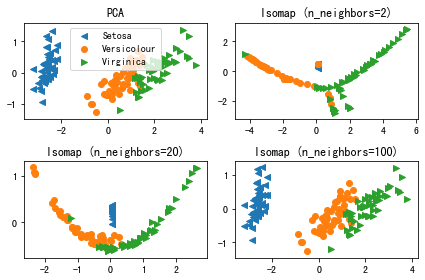

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.manifold import Isomap

iris = datasets.load_iris()
X, y = iris.data, iris.target

plt.subplot(221)
X_pca = PCA(n_components=2).fit_transform(X)
for name, label, m in [('Setosa', 0, '<'), ('Versicolour', 1, 'o'), ('Virginica', 2, '>')]:
    plt.scatter(X_pca[y==label, 0], X_pca[y==label, 1], label=name, marker=m)
plt.legend()
plt.title("PCA")

for idx, neighbor in enumerate([2,20,100]):
    plt.subplot(222+idx)
    isomap = Isomap(n_components=2, n_neighbors=neighbor)
    X_isomap = isomap.fit_transform(X)
    
    for name, label, m in [('Setosa', 0, '<'), ('Versicolour', 1, 'o'), ('Virginica', 2, '>')]:
        plt.scatter(X_isomap[y==label, 0], X_isomap[y==label, 1], label=name, marker=m)
    #plt.legend()
    plt.title("Isomap (n_neighbors=%d)"%neighbor)
plt.tight_layout()
plt.show()

### 局部线性嵌入（Locally Linear Embedding，LLE）

是一种以保持每个样本与邻近样本之间距离作为降维目标的流形学习方法。

步骤：
1. 选择近邻 
2. 建立权重系数矩阵（表达每个样本与邻近样本的关系）
3. 降维（降维后尽量保持前面的权重矩阵）

#### 权重系数矩阵

基本假设是每个样本可以通过近邻结点的线性组合近似的表示。权重系数矩阵中的每个元素值
$w_{ij}$用于表示用样本$j$生成样本$i$时使用的权值，即
$$^{\bar{x}_i}=\sum_{j \in N_i}w_{ij}x_j$$

其中$N_i$是所有邻近点的集合，可以用“最近的k个点”这样的策略定义。$x_j$是第j个真实
的原始特征向量，$^{\bar{x}_i}$是第i个通过近邻点恢复出的特征向量。

#### 寻找最优权重

尽管理想情况下，$^{\bar{x}_i}=x_i$，但是一个样本$x_i$是否真的能从邻近点恢复，
取决于自身的分布情况。所以LLE首先找出使$^{\bar{x}_i}$最接近$x_i$的一组权重系数，优化目标
如下：
$$min\sum_{i}||x_i-^{\bar{x}_i}||^2$$
再加上权重归一化要求，$\sum_{j\in N_i}w_{ij}=1$，可用拉格朗日乘子法求解。

#### 降维

最小化优化目标：
$$J(Y)=\sum_{i=1..n}||y_i-\sum_{j\in N_i}w_{ij}x_j||^2$$

最后上式可转换：
$$J(Y)=trace(Y^T(I-W)^T(I-W)Y)$$(trace是矩阵迹函数，即矩阵对角线元素之和)，
另有归一化条件$Y^TY=nI$，也可用拉格朗日乘子法求解。

#### 用特征值分解求优化问题

最后一步降维时常用特征值分解代替拉格朗日乘子法。因为两个方法最终是一致的，特征值计算更快。

### 拉普拉斯映射(Laplacian Eigenmaps,LE)

与LLE区别在，LLE尽量保持权重系数矩阵进行降维，LE围绕保持拉普拉斯矩阵进行降维。

#### 拉普拉斯矩阵

它是图论中表示无向有权图结构的矩阵。定义如下：

$$L=D-W$$
其中D是度矩阵(对角线元素是该点所有边的权值和，即$d_{ii}=\sum w_{ij}$，其他元素是0)，W是邻接权重矩阵。

#### 降维优化函数

$$J(Y)=\sum_{i,j\in N}||y_i-y_j||^2w_{ij}$$
其中N是所有样本集合，$||y_i-y_j||^2$可以看成两个样本的距离度量，所以该目标函数直观意义是：
- 两样本间原始权重越大，则降维后越应该使两个样本距离变小
- 样本间权值越低，则降维后对整体目标影响越小，也就是说可以离得更远

整理目标函数发现：

$$J(Y)=\sum_{i,j\in N}||y_i-y_j||^2w_{ij}=\sum_{i,j\in N}y_i^2w_{ij}+\sum_{i,j\in N}y_j^2w_{ij}-2\sum_{i,j\in N}2y_iy_jw_{ij}$$

由于$d_{ii}=\sum w_{ij}$，所以上式最终变成：

$$
\begin{align}
J(Y)&=\sum_{i,j\in N}y_i^2w_{ij}+\sum_{i,j\in N}y_j^2w_{ij}-2\sum_{i,j\in N}2y_iy_jw_{ij}\\
&=trace(2Y^T(D-W)Y)\\
&=trace(2Y^TLY)
\end{align}
$$

其中Y是降维后所有样本坐标值，L就是原始样本的拉普拉斯矩阵。

#### 优化函数求解

为防止过拟合，即降维后所有样本有相同的坐标值，这是最小目标。必须加入约束条件$Y^TLY=Y$。这里也用特征值分解就好，因为现在优化目标是$min(trace(2Y^TLY))$，因此只要对L进行特征值分解并取最小的d个特征值对应的特征向量（d是降维后的维度），就可以求得Y。

d:\program\python36\lib\site-packages\sklearn\decomposition\kernel_pca.py:304: RuntimeWarning: invalid value encountered in sqrt
  X_transformed = self.alphas_ * np.sqrt(self.lambdas_)


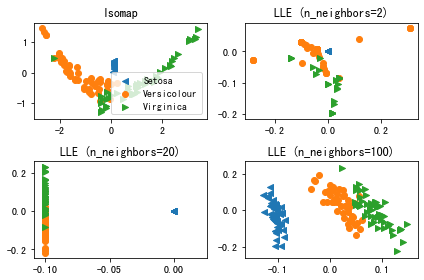

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding as SE

iris = datasets.load_iris()
X, y = iris.data, iris.target

plt.subplot(221)
X_isomap = Isomap(n_components=100).fit_transform(X)
for name, label, m in [('Setosa', 0, '<'), ('Versicolour', 1, 'o'), ('Virginica', 2, '>')]:
    plt.scatter(X_isomap[y==label, 0], X_isomap[y==label, 1], label=name, marker=m)
plt.legend()
plt.title("Isomap")

for idx, neighbor in enumerate([2,20,100]):
    plt.subplot(222+idx)
    lle = LLE(n_components=2, n_neighbors=neighbor)
    X_lle = lle.fit_transform(X)
    
    for name, label, m in [('Setosa', 0, '<'), ('Versicolour', 1, 'o'), ('Virginica', 2, '>')]:
        plt.scatter(X_lle[y==label, 0], X_lle[y==label, 1], label=name, marker=m)
    #plt.legend()
    plt.title("LLE (n_neighbors=%d)"%neighbor)
plt.tight_layout()
plt.show()

d:\program\python36\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
d:\program\python36\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


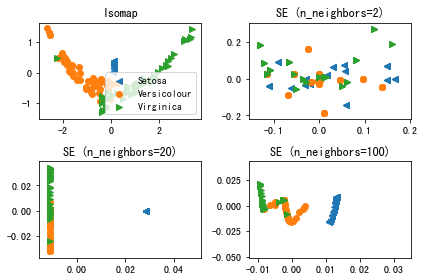

In [8]:
plt.subplot(221)
X_isomap = Isomap(n_components=2).fit_transform(X)
for name, label, m in [('Setosa', 0, '<'), ('Versicolour', 1, 'o'), ('Virginica', 2, '>')]:
    plt.scatter(X_isomap[y==label, 0], X_isomap[y==label, 1], label=name, marker=m)
plt.legend()
plt.title("Isomap")

for idx, neighbor in enumerate([2,20,100]):
    plt.subplot(222+idx)
    se = SE(n_components=2, n_neighbors=neighbor)
    X_se = se.fit_transform(X)
    
    for name, label, m in [('Setosa', 0, '<'), ('Versicolour', 1, 'o'), ('Virginica', 2, '>')]:
        plt.scatter(X_se[y==label, 0], X_se[y==label, 1], label=name, marker=m)
    #plt.legend()
    plt.title("SE (n_neighbors=%d)"%neighbor)
plt.tight_layout()
plt.show()

### 谱聚类

明显是一种聚类模型，相比K-means，计算代价低、适应非凸数据集等特点，特别适应于高维数据
的聚类。

#### 原理

放到这里，没有写在聚类那里，是因为它和拉普拉斯映射有密切关系。

$$谱聚类 = 拉普拉斯映射 + K-means 聚类$$

设目标聚类分组数是k，谱聚类就是对样本执行LE降维到K维后执行centers=k的K-means聚类。

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 2 2 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 1 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
精度是：0.80% 120 150
邻接权重矩阵：
 [[1.         0.9971042  0.99740338 ... 0.84662282 0.84181079 0.86433055]
 [0.9971042  1.         0.9991004  ... 0.84366482 0.83652406 0.86338031]
 [0.99740338 0.9991004  1.         ... 0.8311874  0.82613259 0.85282578]
 ...
 [0.84662282 0.84366482 0.8311874  ... 1.         0.9971042  0.99630684]
 [0.84181079 0.83652406 0.82613259 ... 0.9971042  1.         0.9

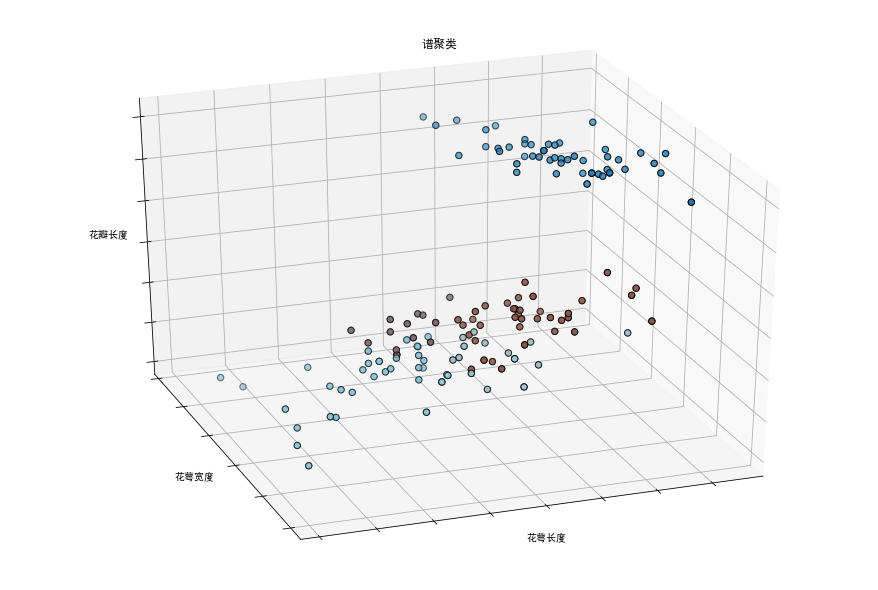

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn import datasets

iris = datasets.load_iris()

x=iris.data[:,:3]
y=iris.target
result=SpectralClustering(n_clusters=3, eigen_solver='arpack',gamma=0.01, 
                      n_neighbors=100, assign_labels='discretize').fit_predict(x)

fig=plt.figure(figsize=(12,8))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(x[:,0],x[:,1],x[:,2],c=result,cmap=plt.cm.tab20, edgecolor='k',s=40)
ax.scatter(x[:,0],x[:,1],x[:,2],c=y,cmap=plt.cm.tab20, edgecolor='k',s=40)
ax.set_title('谱聚类')
ax.set_xlabel('花萼长度')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel('花萼宽度')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel('花瓣长度')
ax.w_zaxis.set_ticklabels([])

#ax.scatter(sc.fit_predict(x),c=y,cmap=plt.cm.Set1, edgecolor='b',s=140)
if(result[0]!=y[0]):
    for index,val in enumerate(result):
        if val==0:
            result[index]=2
        elif val==2:
            result[index]=0
        
print(result,y,sep='\n')
true_partion_sum=0;
for r,l in zip(result,y):
    if(r==l):
        true_partion_sum += 1
        
print("精度是：%.2f%%" % (true_partion_sum/len(y)), true_partion_sum,len(y))
print("邻接权重矩阵：\n",sc.affinity_matrix_)
plt.show()

### 流形学习之t-SNE

t分布随机近邻嵌入，从降维效果来看，是一个流形学习的终极武器，缺点是训练时间较长。

t-SNE假设高维空间符合高斯分布，低维空间符合t分布，以两个分布的Kullback-Leiber散度
(简称KL散度)最小为优化目标。

为啥用t分布，高斯分布在中心极限定理中很是受用，原因是流形学习的**拥挤问题**。

#### 拥挤问题

前面一直假设高维空间样本降维依然尽量保持亲缘性或等距，，这几乎是流形学习的出发点，
但这个实际上很难达到。

t分布从某种程度上缓解了拥挤问题。
1. 只有一个超参数——自由度，这里固定为1
2. 形态上与高斯分布类似，只是二维表现图像的两侧尾部比高斯分布高。自由度越低，
两侧尾部越高；自由度取∞，t分布演变为标准高斯分布。

比较t-分布与标准正态分布


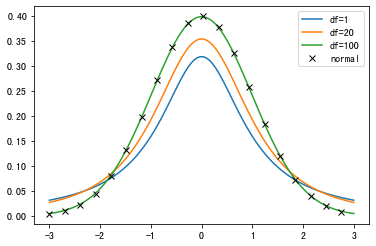

In [2]:
%matplotlib inline
import numpy as np
from scipy.stats import norm
from scipy.stats import t
import matplotlib.pyplot as plt
 
print('比较t-分布与标准正态分布')
x = np.linspace( -3, 3, 100)
plt.plot(x, t.pdf(x,1), label='df=1')
plt.plot(x, t.pdf(x,2), label='df=20')
plt.plot(x, t.pdf(x,100), label = 'df=100')
plt.plot( x[::5], norm.pdf(x[::5]),'kx', label='normal')
plt.legend()
plt.show()

### 综合对比

以一个三维空间中的一个S状流形降到两维为目标，分别使用PCA、LDA、MDS、Isomap、LLE、LE及t-SNE。

standard: 0.11 sec
ltsa: 0.23 sec
hessian: 0.29 sec
Isomap: 0.43 sec
MDS: 4 sec
Laplace Eigenmaps: 0.12 sec
t-SNE: 15 sec
PCA: 0.0045 sec
LDA: 0.0025 sec


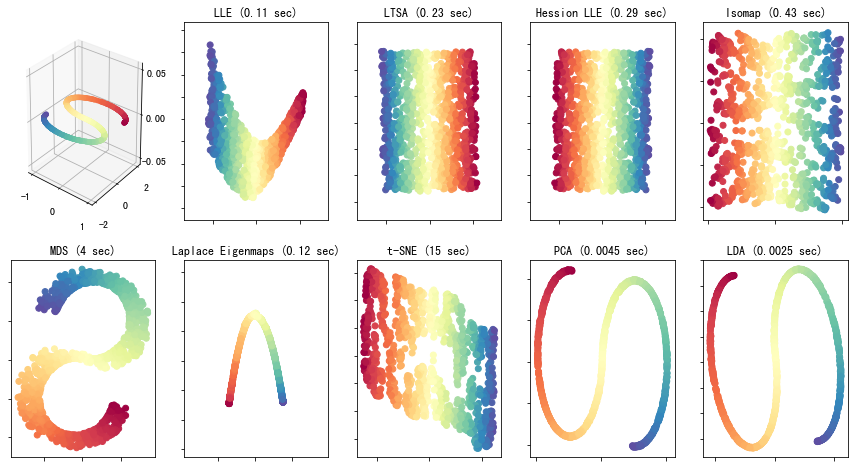

In [11]:
%matplotlib inline
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Axes3D

n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(24, -52) #(z平面仰角，xy的平面方位角)

methods = ['standard', 'ltsa', 'hessian']
labels = ['LLE', 'LTSA','Hession LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components, eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1-t0))
    ax = fig.add_subplot(252+i)
    
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1-t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

#  初始化六种降维模型    
estimators = [(manifold.Isomap(n_neighbors, n_components), "Isomap"), 
              (manifold.MDS(n_components, max_iter=100, n_init=1), "MDS"),
             (manifold.SpectralEmbedding(n_components=n_components,n_neighbors=n_neighbors),
                                        "Laplace Eigenmaps"),
             (manifold.TSNE(n_components=n_components, init='pca', random_state=0),"t-SNE"),
             (PCA(n_components), "PCA"),
             (LDA(n_components=n_components), "LDA")]

# 训练并显示降维结果
for idx, (estimator_obj, estimator_name) in enumerate(estimators):
    t0 = time()
    if estimator_name =='LDA':
        Y = estimator_obj.fit_transform(X, (color).astype(int))
    else:
        Y = estimator_obj.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (estimator_name, t1-t0))
    ax = fig.add_subplot(2,5,5+idx)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (estimator_name, t1-t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
plt.show()